# Homework 2: More Exploratory Data Analysis
## Gene Expression Data and Election Polls 

Due: Thursday, October 2, 2014 11:59 PM

<a href=https://raw.githubusercontent.com/cs109/2014/master/homework/HW2.ipynb download=HW2.ipynb> Download this assignment</a>

#### Submission Instructions
To submit your homework, create a folder named lastname_firstinitial_hw# and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code. Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work.


---


## Introduction

John Tukey wrote in [Exploratory Data Analysis, 1977](http://www.amazon.com/Exploratory-Data-Analysis-Wilder-Tukey/dp/0201076160/ref=pd_bbs_sr_2/103-4466654-5303007?ie=UTF8&s=books&qid=1189739816&sr=8-2): "The greatest value of a picture is when it forces us to notice what we never expected to see." In this assignment we will continue using our exploratory data analysis tools, but apply it to new sets of data: [gene expression](http://en.wikipedia.org/wiki/Gene_expression) and polls from the [2012 Presidental Election](http://en.wikipedia.org/wiki/United_States_presidential_election,_2012) and from the [2014 Senate Midterm Elections](http://en.wikipedia.org/wiki/United_States_Senate_elections,_2014).   

**First**: You will use exploratory data analysis and apply the [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) to a gene expression data matrix to determine if the the date that the gene expression samples are processed has large effect on the variability seen in the data.  

**Second**: You will use the polls from the 2012 Presidential Elections to determine (1) Is there a pollster bias in presidential election polls? and (2) Is the average of polls better than just one poll?

**Finally**: You will use the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to extract the polls for the current 2014 Senate Midterm Elections and provide a preliminary prediction of the result of each state.

#### Data

We will use the following data sets: 

1. A gene expression data set called `exprs_GSE5859.csv` and sample annotation table called `sampleinfo_GSE5859.csv` which are both available on Github in the 2014_data repository: [expression data set](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sample annotation table](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv).  

2. Polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama). The polls we will use are from the [Huffington Post Pollster](http://elections.huffingtonpost.com/pollster).  

3. Polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api). 

---

## Load Python modules

In [38]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
from io import StringIO
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations

## Problem 1

In this problem we will be using a [gene expression](http://en.wikipedia.org/wiki/Gene_expression) data set obtained from a [microarray](http://en.wikipedia.org/wiki/DNA_microarray) experiement [Read more about the specific experiment here](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE5859).  There are two data sets we will use:  

1. The gene expression intensities where the rows represent the features on the microarray (e.g. genes) and the columsns represent the different microarray samples.  

2. A table that contains the information about each of the samples (columns in the gene expression data set) such as the sex, the age, the treatment status, the date the samples were processed.  Each row represents one sample. 

#### Problem 1(a) 

Read in the two files from Github: [exprs_GSE5859.csv](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sampleinfo_GSE5859.csv](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv) as pandas DataFrames called `exprs` and `sampleinfo`. Use the gene names as the index of the `exprs` DataFrame.

In [39]:
#your code here
url_exprs = "exprs_GSE5859.csv"
exprs = pd.read_csv(url_exprs, index_col=0)

url_sampleinfo = "sampleinfo_GSE5859.csv"
sampleinfo = pd.read_csv(url_sampleinfo)

Make sure the order of the columns in the gene expression DataFrame match the order of file names in the sample annotation DataFrame. If the order of the columns the `exprs` DataFrame do not match the order of the file names in the `sampleinfo` DataFrame, reorder the columns in the `exprs` DataFrame. 

**Note**: The column names of the gene expression DataFrame are the filenames of the orignal files from which these data were obtained.  

**Hint**: The method `list.index(x)` [[read here](https://docs.python.org/2/tutorial/datastructures.html)] can be used to return the index in the list of the first item whose value is x. It is an error if there is no such item. To check if the order of the columns in `exprs` matches the order of the rows in `sampleinfo`, you can check using the method `.all()` on a Boolean or list of Booleans: 

Example code: `(exprs.columns == sampleinfo.filename).all()`

In [40]:
(exprs.columns == sampleinfo.filename).all()

False

Show the head of the two tables: `exprs` and `sampleinfo`. 

In [41]:
exprs.head()

,GSM25581.CEL.gz,GSM25681.CEL.gz,GSM136524.CEL.gz,GSM136707.CEL.gz,GSM25553.CEL.gz,GSM136676.CEL.gz,GSM136711.CEL.gz,GSM136542.CEL.gz,GSM136535.CEL.gz,GSM25399.CEL.gz,...,GSM48650.CEL.gz,GSM25687.CEL.gz,GSM25685.CEL.gz,GSM136549.CEL.gz,GSM25427.CEL.gz,GSM25525.CEL.gz,GSM25349.CEL.gz,GSM136727.CEL.gz,GSM25626.CEL.gz,GSM136725.CEL.gz
1007_s_at,6.333951,5.736190,6.156754,6.513010,6.061013,6.506493,6.863426,6.369645,6.646321,5.810930,...,7.082636,6.315866,7.010165,6.460107,6.122355,6.330314,6.627014,6.133068,6.419444,6.488579
1053_at,7.255622,7.399993,7.491967,7.006123,7.250995,7.082581,6.842236,7.048487,7.042361,6.666625,...,6.599718,7.412731,7.274429,6.928642,7.168782,7.235648,6.939184,7.280781,6.351776,7.517410
117_at,5.760106,4.825169,5.039387,5.414160,5.205697,5.300078,5.099337,5.156459,5.736109,5.807496,...,6.231457,5.240717,5.275062,5.759827,5.409720,5.491938,5.113570,5.401876,5.537605,5.247190
121_at,6.935451,7.025210,7.543667,7.959781,7.223323,8.006816,8.102504,7.434617,7.532321,7.711461,...,8.215096,7.677593,7.923624,7.219401,7.432338,6.785174,7.833862,7.607461,7.302935,7.331864
1255_g_at,3.597872,3.108801,3.128269,3.364947,3.125909,3.186834,3.311022,3.092042,3.167737,2.969579,...,3.331424,3.043856,3.151900,3.132253,3.250600,2.984125,3.152269,3.225123,3.222731,3.175846


In [42]:
sampleinfo.head()

,ethnicity,date,filename,sex
0,CEU,2003-02-04,GSM25349.CEL.gz,M
1,CEU,2003-02-04,GSM25350.CEL.gz,M
2,CEU,2002-12-17,GSM25356.CEL.gz,M
3,CEU,2003-01-30,GSM25357.CEL.gz,M
4,CEU,2003-01-03,GSM25358.CEL.gz,M


#### Problem 1(b)

Extract the year and month as integers from the `sampleinfo` table. 

**Hint**: To convert a Series or a column of a pandas DataFrame that contains a date-like object, you can use the `to_datetime` function [[read here](http://pandas.pydata.org/pandas-docs/stable/timeseries.html)].  This will create a `DatetimeIndex` which can be used to extract the month and year for each row in the DataFrame. 

In [43]:
#your code here
sampleinfo["date"] = pd.to_datetime(sampleinfo.date)
sampleinfo["month"] = map(lambda x: x.month, sampleinfo.date)
sampleinfo["year"] = map(lambda x: x.year, sampleinfo.date)

#### Problem 1(c)

Convert the dates in the `date` column from the `sampleinfo` table into days since October 31, 2002. Add a column to the `sampleinfo` DataFrame titled `elapsedInDays` containing the days since October 31, 2002.  Show the head of the `sampleinfo` DataFrame which includes the new column.  

**Hint**: Use the `datetime` module to create a new `datetime` object for the specific date October 31, 2002. Then, subtract the October 31, 2002 date from each date from the `date` column in the `sampleinfo` DataFrame. 

In [44]:
#your code here
oct31 = dt.datetime(2002,10,31,0,0)
oct31

datetime.datetime(2002, 10, 31, 0, 0)

In [45]:
sampleinfo["elapsedInDays"] = map(lambda x: (x - oct31).days, sampleinfo.date)
sampleinfo.head()

,ethnicity,date,filename,sex,month,year,elapsedInDays
0,CEU,2003-02-04,GSM25349.CEL.gz,M,<map object at 0x000002061B7E9860>,<map object at 0x000002061B7E9550>,<map object at 0x000002061D2B1400>
1,CEU,2003-02-04,GSM25350.CEL.gz,M,<map object at 0x000002061B7E9860>,<map object at 0x000002061B7E9550>,<map object at 0x000002061D2B1400>
2,CEU,2002-12-17,GSM25356.CEL.gz,M,<map object at 0x000002061B7E9860>,<map object at 0x000002061B7E9550>,<map object at 0x000002061D2B1400>
3,CEU,2003-01-30,GSM25357.CEL.gz,M,<map object at 0x000002061B7E9860>,<map object at 0x000002061B7E9550>,<map object at 0x000002061D2B1400>
4,CEU,2003-01-03,GSM25358.CEL.gz,M,<map object at 0x000002061B7E9860>,<map object at 0x000002061B7E9550>,<map object at 0x000002061D2B1400>


#### Problem 1(d)

Use exploratory analysis and the singular value decomposition (SVD) of the gene expression data matrix to determine if the date the samples were processed has large effect on the variability seen in the data or if it is just ethnicity (which is confounded with date).

**Hint**: See the end of the [lecture from 9/23/2014 for help with SVD](http://nbviewer.ipython.org/github/cs109/2014/blob/master/lectures/lecture07/data_scraping_transcript.ipynb). 

First subset the the `sampleinfo` DataFrame to include only the CEU ethnicity.  Call this new subsetted DataFrame `sampleinfoCEU`.  Show the head of `sampleinfoCEU` DataFrame. 

In [46]:
#your code here
sampleinfoCEU = sampleinfo[sampleinfo.ethnicity == "CEU"]
sampleinfoCEU.head()

,ethnicity,date,filename,sex,month,year,elapsedInDays
0,CEU,2003-02-04,GSM25349.CEL.gz,M,<map object at 0x000002061B7E9860>,<map object at 0x000002061B7E9550>,<map object at 0x000002061D2B1400>
1,CEU,2003-02-04,GSM25350.CEL.gz,M,<map object at 0x000002061B7E9860>,<map object at 0x000002061B7E9550>,<map object at 0x000002061D2B1400>
2,CEU,2002-12-17,GSM25356.CEL.gz,M,<map object at 0x000002061B7E9860>,<map object at 0x000002061B7E9550>,<map object at 0x000002061D2B1400>
3,CEU,2003-01-30,GSM25357.CEL.gz,M,<map object at 0x000002061B7E9860>,<map object at 0x000002061B7E9550>,<map object at 0x000002061D2B1400>
4,CEU,2003-01-03,GSM25358.CEL.gz,M,<map object at 0x000002061B7E9860>,<map object at 0x000002061B7E9550>,<map object at 0x000002061D2B1400>


Next, subset the `exprs` DataFrame to only include the samples with the CEU ethnicity. Name this new subsetted DataFrame `exprsCEU`. Show the head of the `exprsCEU` DataFrame. 

In [24]:
#your code here
exprsCEU = exprs[sampleinfoCEU.filename]
exprsCEU.head()

,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz
1007_s_at,6.627014,6.249807,5.934128,6.145268,6.091270,6.041186,6.050375,6.063847,6.226106,6.358282,...,6.501510,6.558100,6.618286,6.869995,5.981000,6.403285,6.248702,6.488579,6.809481,6.133068
1053_at,6.939184,6.818038,7.047962,7.422477,7.272361,7.128216,6.750719,6.836287,6.738022,7.367895,...,7.066686,7.386702,6.407958,7.089180,7.120923,7.018998,7.155419,7.517410,7.200596,7.280781
117_at,5.113570,5.074096,5.371201,5.266550,5.342047,5.063876,5.315898,5.483652,6.689444,6.482782,...,5.600514,5.232676,5.630720,4.944748,5.275577,5.770358,5.616842,5.247190,5.237239,5.401876
121_at,7.833862,7.780682,7.458197,7.655948,7.546555,7.072670,7.092984,6.954225,7.489785,7.388539,...,7.437535,7.714650,7.416252,7.746448,8.001434,7.626723,7.452299,7.331864,7.357102,7.607461
1255_g_at,3.152269,3.111747,3.018932,3.154545,3.107954,3.224284,3.114241,3.044975,3.304038,2.887919,...,3.009983,3.151203,3.199709,3.159496,3.149710,3.242780,3.433125,3.175846,3.105092,3.225123


Check to make sure the order of the columns in the `exprsCEU` DataFrame matches the rows in the `sampleinfoCEU` DataFrame.  

In [25]:
#your code here
(exprsCEU.columns == sampleinfoCEU.filename).all()

True

Compute the average gene expression intensity in the `exprsCEU` DataFrame across all the samples. For each sample in the `exprsCEU` DataFrame, subtract the average gene expression intensity from each of the samples. Show the head of the mean normalized gene expression data.  

In [26]:
#your code here
data = exprsCEU.apply(lambda x: x - exprsCEU.mean(axis=1), axis = 0)
data.head()

,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz
1007_s_at,0.365059,-0.012149,-0.327827,-0.116687,-0.170685,-0.220769,-0.211580,-0.198109,-0.035849,0.096327,...,0.239554,0.296144,0.356331,0.608040,-0.280956,0.141330,-0.013254,0.226624,0.547526,-0.128887
1053_at,-0.136032,-0.257178,-0.027254,0.347260,0.197144,0.053000,-0.324497,-0.238930,-0.337195,0.292678,...,-0.008531,0.311485,-0.667259,0.013964,0.045706,-0.056219,0.080203,0.442193,0.125379,0.205564
117_at,-0.490556,-0.530031,-0.232926,-0.337577,-0.262080,-0.540250,-0.288228,-0.120475,1.085317,0.878655,...,-0.003613,-0.371451,0.026594,-0.659379,-0.328549,0.166231,0.012716,-0.356936,-0.366887,-0.202251
121_at,0.418026,0.364847,0.042362,0.240113,0.130720,-0.343165,-0.322852,-0.461611,0.073949,-0.027296,...,0.021700,0.298814,0.000417,0.330612,0.585598,0.210887,0.036463,-0.083972,-0.058733,0.191626
1255_g_at,0.018335,-0.022187,-0.115002,0.020611,-0.025980,0.090351,-0.019693,-0.088959,0.170104,-0.246015,...,-0.123951,0.017269,0.065775,0.025562,0.015776,0.108846,0.299192,0.041912,-0.028842,0.091189


Using this mean normalized gene expression data, compute the projection to the first Principal Component (PC1).  

**Hint**: Use the `numpy.linalg.svd()` function in the `numpy.linalg` module (or the `scipy.linalg.svd()` function in the `scipy.linalg` module) to apply an [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) to a matrix.  

In [27]:
#your code here
U,s,Vh = lin.svd(data.values)
V = Vh.T

Create a histogram using the values from PC1.  Use a bin size of 25.  

Text(0.5,1,'Distribution of the values from PC1')

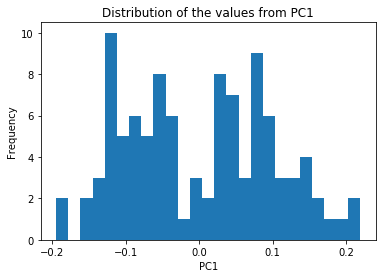

In [28]:
#your code here
plt.hist(V[:,0], bins = 25)
plt.xlabel('PC1')
plt.ylabel('Frequency')
plt.title('Distribution of the values from PC1')

Create a scatter plot with the days since October 31, 2002 on the x-axis and PC1 on the y-axis.

RuntimeError: matplotlib does not support generators as input

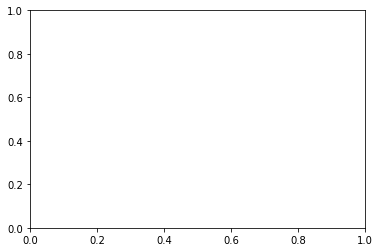

In [36]:
#your code here
plt.scatter(sampleinfoCEU.elapsedInDays, V[:,0])
plt.xlabel('Date sample was processed (Number of days since Oct 31, 2012)')
plt.ylabel('PC1')
plt.title('Relationship between the PC1 and the date the samples were processed')

Around what day do you notice a difference in the way the samples were processed?

RuntimeError: matplotlib does not support generators as input

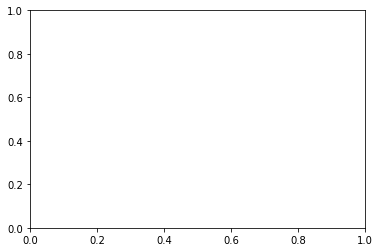

In [21]:
#your code here
plt.scatter(sampleinfoCEU.elapsedInDays, V[:,0])
plt.xlim(0,160)
plt.xlabel('Date sample was processed (Number of days since Oct 31, 2012)')
plt.ylabel('PC1')
plt.title('Relationship between the PC1 and the date the samples were processed')
plt.axvline(x=100, color='r')

Answer: There is a difference around day 100. 

## Discussion for Problem 1

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

Using exploratory data analysis and the SVD of the gene expression data matrix, we see the date the samples were processed does have a large effect on the variability seen in the data. This can been seen in the scatter plots in Problem 1(d) which shows a difference around day 100.  

---


## Problem 2: Is there a pollster bias in presidential election polls?

#### Problem 2(a)

The [HuffPost Pollster](http://elections.huffingtonpost.com/pollster) contains many political polls. You can access these polls from individual races as a CSV but you can also access polls through the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to access the data.  

Read in the polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama) into a pandas DataFrame called `election`. For this problem, you may read in the polls for this race directly using [the CSV file](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv) available from the HuffPost Pollster page.

In [80]:
#your code here
url = "http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv"
source = requests.get(url).text
s = StringIO(source)
election = pd.DataFrame.from_csv(s, index_col=None).convert_objects(
            convert_dates="coerce", convert_numeric=True) # Access polls as a CSV file

Show the head of the `election` DataFrame. 

In [81]:
#your code here
election.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Pollster URL,Source URL,Partisan,Affiliation
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06 08:40:26,1000,Likely Voters,Live Phone,47,47,6,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None
1,UPI/CVOTER,2012-11-03,2012-11-05,2012-11-05 18:30:15,3000,Likely Voters,Live Phone,49,48,NaN,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06 09:22:02,872,Likely Voters,Automated Phone,48,48,4,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None
3,JZ Analytics/Newsmax,2012-11-03,2012-11-05,2012-11-06 07:38:41,1041,Likely Voters,Internet,47,47,6,http://elections.huffingtonpost.com/pollster/p...,NaN,Sponsor,Rep
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06 08:47:50,1500,Likely Voters,Automated Phone,48,49,NaN,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None


How many polls were conducted in November? Define this number as M.  

**Hint**: Subset the `election` DataFrame for only dates in the `Start Date` column that are in November 2012.  

In [82]:
#your code here
filtered = election[map(lambda x: (x.month == 11) and (x.year ==2012), election["Start Date"])]
filtered.drop_duplicates('Pollster', inplace = True) # Removes duplicate pollsters
M = len(filtered)
print "Number of polls in November: %i" % M 

Number of polls in November: 18


Answer: There were 18 polls with a Start Date in November after accounting for multiple polls within a given pollster (or 19 polls total with a Start Date in November). 

What was the median of the number of observations in the November polls? Define this quantity as N. 

In [83]:
#your code here
N = np.median(filtered["Number of Observations"])
print N

1200.0


Answer: The median number of observations in the November polls was 1200. 

#### Problem 2(b)

Using the median sample size $N$ from Problem 2(a), simulate the results from a single poll:  simulate the number of votes for Obama out of a sample size $N$ where $p$ = 0.53 is the percent of voters who are voting for Obama.  

**Hint**: Use the binomial distribution with parameters $N$ and $p$ = 0.53. 

In [84]:
#your code here

To simulate the *number* of votes for Obama from a single poll, we can use the `random.binomial` function in `numpy` to simulate one binomial random variable with a sample size $N$ and $p$ which is the percent of voters who are voting for Obama. 

In [85]:
p = 0.53
"Simulated number of votes for Obama: %i" % np.random.binomial(N, p, size=1)

'Simulated number of votes for Obama: 645'

Now, perform a Monte Carlo simulation to obtain the estimated percentage of Obama votes with a sample size $N$ where $N$ is the median sample size calculated in Problem 2(a). Let $p$=0.53 be the percent of voters are voting for Obama. 

**Hint**: You will repeat the simulation above 1,000 times and plot the distribution of the estimated *percent* of Obama votes from a single poll.  The results from the single poll you simulate is random variable and will be different every time you sample. 

In [86]:
#your code here

To simulate the the estimate *percentage* of Obama votes, we can repeat the above simulation using a Bernoulli distribution, but just divide by the total number of votes. 

In [87]:
p = 0.53
B = 1000
obs = np.random.binomial(N, p, size = B) / N

We can also write this in terms of a Bernoulli random variable $X$ where $X$ has a binary outcome with probability $p$ of success where 
$$E(X) = p$$ 
and 
$$Var(X) = p(1-p)$$

In a single simulation, we simulate N binary outcomes of 1 or 0 representing a vote for Obama or not where N represents the poll sample size.  The average of the binary outcomes represents the *percent* of Obama votes from a single poll.  We repeat this process 1000 times. 

In [88]:
p = 0.53
B = 1000
obs = map(lambda x: np.mean(np.random.binomial(1, p, size = N)), xrange(B))

Plot the distribution of the estimated percentage of Obama votes from your single poll. What is the distribution of the estimated percentage of Obama votes? 

(array([   1.,   21.,   39.,  100.,  216.,  213.,  235.,  115.,   50.,   10.]),
 array([ 0.48166667,  0.49041667,  0.49916667,  0.50791667,  0.51666667,
         0.52541667,  0.53416667,  0.54291667,  0.55166667,  0.56041667,
         0.56916667]),
 <a list of 10 Patch objects>)

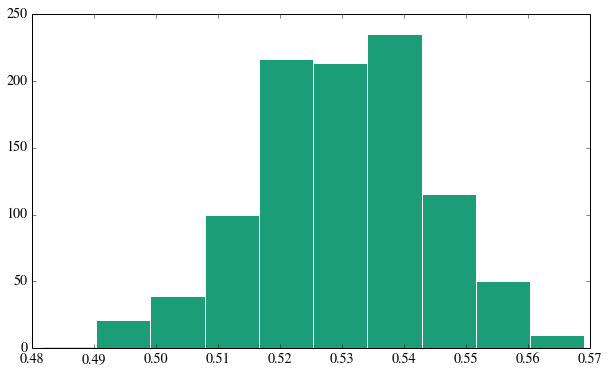

In [89]:
#your code here
plt.hist(obs)

At first glance the distribution looks normally distributed. We can use a qqplot to visually inspect if this distribution is normally distributed. 

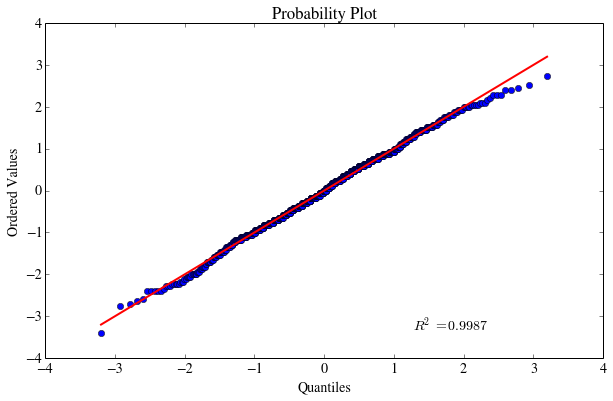

In [90]:
import scipy.stats as stats
stats.probplot((obs - np.mean(obs)) / np.std(obs, ddof=1), dist="norm", plot = plt)
plt.show()

Answer: From the histogram and qqplot, we see the distribution looks normally distributed. 

What is the standard error (SE) of the estimated percentage from the poll. 

**Hint**: Remember the SE is the standard deviation (SD) of the distribution of a random variable. 

In this example, the standard error (SE) is the standard deviation of the distribution of the percent of Obama votes from a single poll.  Therefore, we can compute the standard deviation as

In [91]:
#your code here
np.std(obs, ddof=1)

0.014217259754234046

From the lecture we saw if we observe $N$ Bernoulli random variables $(X_1, \ldots X_N)$, then 
$$ \mbox{E}(\bar{X}) = \frac{1}{N} \sum_{i=1}^N p = p$$
and 
$$\mbox{Var}(\bar{X})= \frac{1}{N^2} \sum_{i=1}^N p(1-p) = \frac{p(1-p)}{N}$$

In our example, we assume each $X_i$ is a Bernoulli distribution with $p$ = 0.53. Therefore, if $N$ = 1200, we can analytically calculate the standard deviation of $\bar{X}$ directly and compare to the standard error above

In [92]:
np.sqrt((0.53 * 0.47) / 1200)

0.014407752542757436

#### Problem 2(c)

Now suppose we run M polls where M is the number of polls that happened in November (calculated in Problem 2(a)). Run 1,000 simulations and compute the mean of the M polls for each simulation. 

First, let's recall what M and N were in Problem 2(a): 

In [93]:
"Number of polls in November: %i" % M

'Number of polls in November: 18'

In [94]:
"Median size of polls in November: %i" % N

'Median size of polls in November: 1200'

Within one iteration of the simulation, we want to simulate M polls each measuring the *percent* of Obama votes out of a sample size of N. We can use again the Bernoulli distribution with parameter $p$. We simulate the *percentage* of Obama votes from M polls and compute the mean across the M polls using `np.mean`.  


In [95]:
# Represents the percentage of Obama votes from M polls
def simulatePolls(p, N, M):
    """ Function to simulate the results 
    of M polls each measuring the percent
    of Obama votes out of a sample size of N
    with probability p of voting for Obama
    
    M = Number of polls to simulate
    N = Sample size of each poll
    p = Probability of voting for Obama """
    
    return map(lambda x: np.mean(np.random.binomial(1, p, size = N)), xrange(M))

simulatePolls(p, N, M) 

[0.56166666666666665,
 0.54583333333333328,
 0.51083333333333336,
 0.55666666666666664,
 0.51833333333333331,
 0.54000000000000004,
 0.51333333333333331,
 0.52000000000000002,
 0.53166666666666662,
 0.52749999999999997,
 0.53333333333333333,
 0.52916666666666667,
 0.53166666666666662,
 0.52666666666666662,
 0.53916666666666668,
 0.53166666666666662,
 0.53166666666666662,
 0.53416666666666668]

Now, we want to repeat this simulation 1000 times. For every iteration of the simulation, we will compute the average across the 19 polls (or average of averages).   

In [96]:
p = 0.53
B = 1000
mom = map(lambda y: np.mean(simulatePolls(p, N, M)), xrange(B))

What is the distribution of the average of polls?

**Hint**: Show a plot. 

(array([  10.,   48.,  109.,  216.,  253.,  220.,   84.,   48.,   10.,    2.]),
 array([ 0.52   ,  0.52225,  0.5245 ,  0.52675,  0.529  ,  0.53125,
         0.5335 ,  0.53575,  0.538  ,  0.54025,  0.5425 ]),
 <a list of 10 Patch objects>)

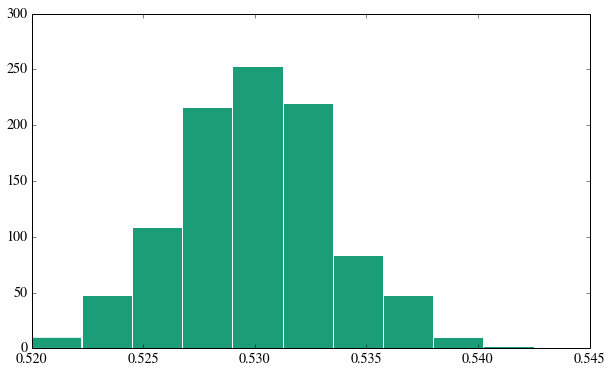

In [97]:
#your code here
plt.hist(mom)

Using a qqplot, we can compare this distribuiton to a normal distribution. 

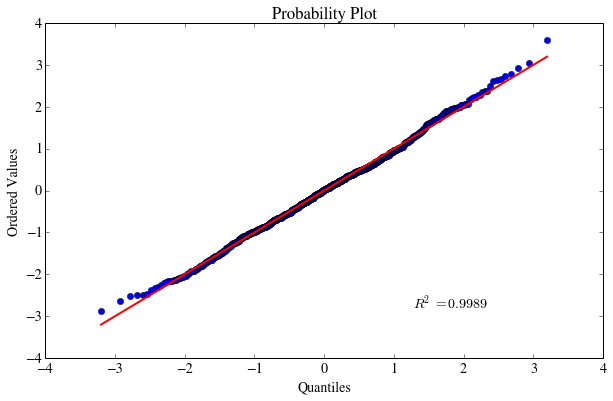

In [98]:
stats.probplot((mom - np.mean(mom)) / np.std(mom, ddof=1), dist="norm", plot = plt)
plt.show()

Answer: Using a histogram and qqplot, we can see this distribution is very similar to a normal distribution. 

What is the standard error (SE) of the average of polls? 

In [99]:
#your code here
np.std(mom, ddof = 1)

0.003470334629167922

Answer: 

In [100]:
"The SE of the average of polls is %g" % np.round(np.std(mom, ddof = 1), 5)

'The SE of the average of polls is 0.00347'

Is the SE of the average of polls larger, the same, or smaller than that the SD of a single poll (calculated in Problem 2(b))? By how much?

**Hint**: Compute a ratio of the two quantities.  

In [101]:
#your code here
ratio = np.std(mom, ddof = 1) / np.std(obs, ddof = 1) 

"The ratio of the SE of the average of polls to the SD of a single poll is %g" % ratio

'The ratio of the SE of the average of polls to the SD of a single poll is 0.244093'

Answer: The SE of the average of polls is smaller than the SD of a single poll by approximately factor of 4. 

#### Problem 2(d) 

Repeat Problem 2(c) but now record the *across poll* standard deviation in each simulation. 

In [102]:
#your code here
B = 1000
p = 0.53
sds = map(lambda y: np.std(simulatePolls(p, N, M), ddof = 0), xrange(B))

What is the distribution of the *across M polls* standard deviation?

**Hint**: Show a plot. 

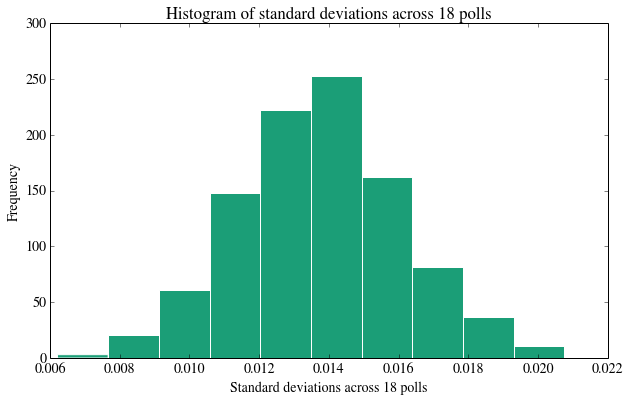

In [103]:
#your code here
plt.hist(sds)
plt.xlabel('Standard deviations across %i polls' % M)
plt.ylabel('Frequency')
plt.title('Histogram of standard deviations across %i polls' % M)

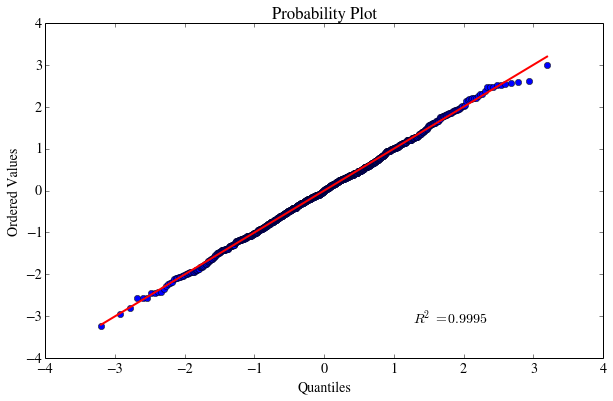

In [104]:
stats.probplot((sds - np.mean(sds)) / np.std(sds, ddof=1), dist="norm", plot = plt)
plt.show()

Answer: Using the histogram and qqplot, we see the distribution is normally distributed. 

#### Problem 2(e) 

What is the standard deviation of M polls in our real (not simulated) 2012 presidential election data ? 

In [105]:
#your code here
thesd = np.std(filtered["Obama"] / 100, ddof = 0)
thesd

0.010829771494228929

Is this larger, the same, or smaller than what we expeced if polls were not biased.

In [106]:
#your code here
thesd / np.mean(sds)

0.78702707298570951

Answer: The standard deviation in our real 2012 presidential election data is smaller than what we expect if the polls were not biased. 

Another way of comparing the standard deviation of the M polls in the 2012 presidential eletion data is to compare it directly to the distribuiton of `sds`. We can calculate a *p*-value or the probability of seeing values as large as `thesd` or larger. 

In [107]:
np.mean(thesd > sds)

0.10000000000000001

We see `thesd` is consistent with the null distribution of `sds`.  

#### Problem 2(f)

**For AC209 Students**: Learn about the normal approximation for the binomial distribution and derive the results of Problem 2(b) and 2(c) analytically (using this approximation). Compare the results obtained analytically to those obtained from simulations.

**Solution:** A random variable $X$ that has a [Binomial distribution](http://en.wikipedia.org/wiki/Binomial_distribution) with $N$ independent trials of a binary outcome (e.g. yes/no) each with probability of success $p$ can be [approximated by a normal distribution](http://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation) if $n$ is large enough. Another way of writing this is if $X$ has a Binomial distribution with parameters $N$ and $p$, $X \sim Bin(N,p)$, and $N$ is "large enough", then $X$ can be approximated by a normal distribution with mean $Np$ and variance $Np(1-p)$, or $X \sim Normal(Np, Np(1-p))$. 

In Problem 2(b), we are asking about the *percentage* of Obama votes, therefore we are actually interested in $Y_i = \frac{X_i}{N}$ where $X_i \sim Bin(N, p)$. In this case, $\mbox{Var}(Y_i)  = p(1-p)$. To estimate the standard deviation of $\bar{Y}$, 

$$\mbox{Var}(\bar{Y}) =  \frac{1}{N^2} \sum_{i=1}^N p(1-p) = \frac{p(1-p)}{N}$$

Thus, we can analytically compute the standard deviation of $\bar{Y}$ using $\sqrt{\frac{p(1-p)}{N}}$ and compare to the standard deviation obtained from simulations. 

In [108]:
# Standard deviation from simulations in 2(b) 
print "SD from simulations: %g" % np.std(obs, ddof=1)

# Standard deviation computed analytically
print "SD using normal approximation %g" % np.sqrt(p * (1-p)/ N)

SD from simulations: 0.0142173
SD using normal approximation 0.0144078


In Problem 2(c), we are asking about the *percentage* of Obama votes from averaged across M polls.  Above we saw the variance for each poll is $\frac{p(1-p)}{N}$. Therefore we can treat the variance at the poll level as $\sigma_{poll}^2 = \frac{p(1-p)}{N}$. Then, when we average across M polls the variance becomes $\sigma_{poll}^2 / M = \frac{p(1-p)}{N \cdot M }$




In [109]:
# Standard deviation from simulations in 2(c) 
print "SD from simulations: %g" % np.std(mom, ddof=1)

# Standard deviation computed analytically
print "SD using normal approximation %g" % np.sqrt((p * (1-p)/ N) / M)

SD from simulations: 0.00347033
SD using normal approximation 0.00339594


Answer: We see the SD from the simulations match the analytical results using the normal approximation.  

## Discussion for Problem 2

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

In this problem we considered all the polls from pollsters in November 2012. After removing polls that came from the same pollster in Nov 2012, we did not see any pollster bias.  The standard deviation from the 2012 Presidential Election was smaller than what we expect by chance.  

---


## Problem 3: Is the average of polls better than just one poll?

#### Problem 3(a)

Most undecided voters vote for one of the two candidates at the election. Therefore, the reported percentages underestimate the final value of both candidates. However, if we assume the undecided will split evenly, then the observed difference should be an unbiased estimate of the final difference. 

Add a new column to the `election` DataFrame containg the difference between Obama and Romeny called `Diff`. 

In [110]:
#your code here
election["Diff"] = (election.Obama / 100) - (election.Romney / 100)
election.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Pollster URL,Source URL,Partisan,Affiliation,Diff
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06 08:40:26,1000,Likely Voters,Live Phone,47,47,6,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None,0.00
1,UPI/CVOTER,2012-11-03,2012-11-05,2012-11-05 18:30:15,3000,Likely Voters,Live Phone,49,48,NaN,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None,0.01
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06 09:22:02,872,Likely Voters,Automated Phone,48,48,4,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None,0.00
3,JZ Analytics/Newsmax,2012-11-03,2012-11-05,2012-11-06 07:38:41,1041,Likely Voters,Internet,47,47,6,http://elections.huffingtonpost.com/pollster/p...,NaN,Sponsor,Rep,0.00
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06 08:47:50,1500,Likely Voters,Automated Phone,48,49,NaN,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None,-0.01


#### Problem 3(b)

Make a plot of the differences for the week before the election (e.g. 5 days) where the days are on the x-axis and the differences are on the y-axis.  Add a horizontal line showing 3.9%: the difference between Obama and Romney on election day.


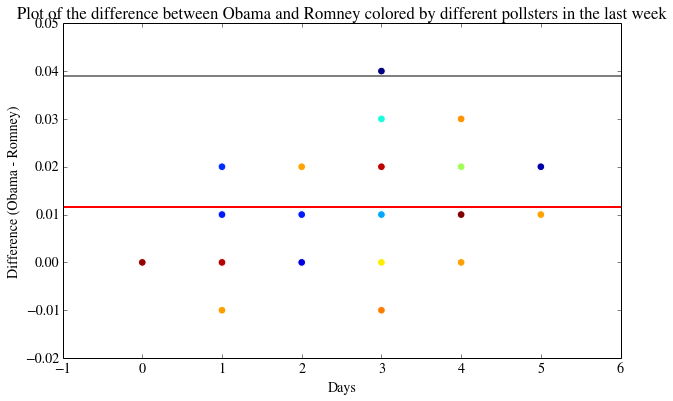

In [111]:
#your code here
last_day = max(election["Start Date"])
filtered = election[map(lambda x: (last_day - x).days <= 5, election["Start Date"]) ]
filtered = filtered.sort(columns=["Start Date"])
days= map(lambda x: (last_day - x).days , filtered["Start Date"])

color_map = {}
for i, p in enumerate(set(filtered.Pollster)):
    color_map[p] = np.random.rand();

plt.scatter(days, filtered.Diff, c = map(lambda x: color_map[x], filtered.Pollster),  s=60 )
plt.axhline(y=0.039, c = "gray")
plt.axhline(y=np.mean(filtered.Diff), c = "red")
plt.xlabel("Days")
plt.ylabel("Difference (Obama - Romney)")
plt.title("Plot of the difference between Obama and Romney colored by different pollsters in the last week")



#### Problem 3(c) 

Make a plot showing the differences by pollster where the pollsters are on the x-axis and the differences on the y-axis. 

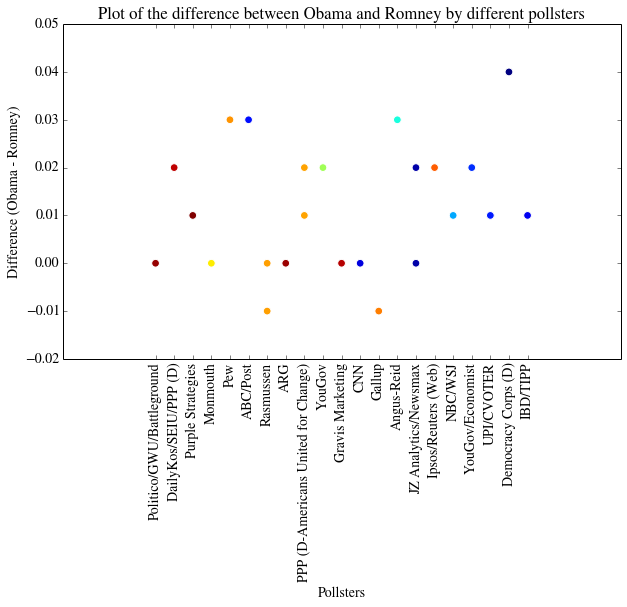

In [112]:
#your code here
pollster_map = {}

polls = list(set(filtered.Pollster))

for i, p in enumerate(polls):
    pollster_map[p] = i

plt.scatter(map(lambda x: pollster_map[x],filtered.Pollster), filtered.Diff, \
            c = map(lambda x: color_map[x],filtered.Pollster),s=60)
plt.xticks(range(len(polls)), polls, rotation = 90)
plt.xlabel("Pollsters")
plt.ylabel("Difference (Obama - Romney)")
plt.title("Plot of the difference between Obama and Romney by different pollsters")
plt.show()

Is the *across poll* difference larger than the *between pollster* difference? 

Answer: For this question, we can compare the variability *within* each pollster (*across* a set of polls) compared to the variability *between* each pollster.  From these two visualization it is clear that the *between* pollster difference is larger. 

#### Problem 3(d)

Take the average for each pollster and then compute the average of that. Given this difference how confident would you have been of an Obama victory?

**Hint**: Compute an estimate of the SE of this average based exclusively on the observed data. 

In [113]:
#your code here
aggr  = filtered.groupby("Pollster").mean()
print "Average across pollsters: %g" % np.round(np.mean(aggr.Diff),4)
print "Standard error: %g" % np.std(aggr.Diff, ddof = 0)


Average across pollsters: 0.0124
Standard error: 0.0129669


Answer: Given the large standard error, I would not have been very confident in the Obama victory. 

#### Problem 3(e)

**For AC209 Students**: Show the difference against time and see if you can detect a trend towards the end. Use this trend to see if it improves the final estimate.

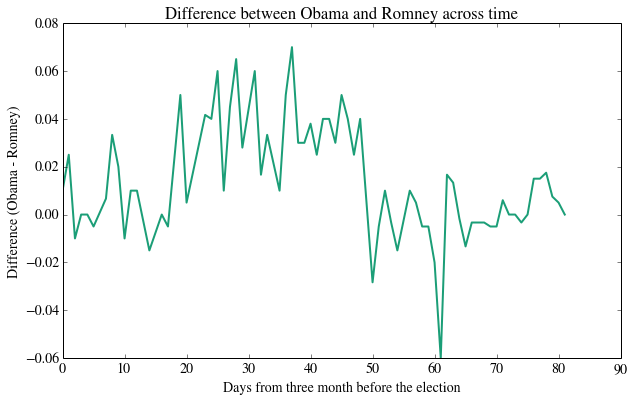

In [114]:
#your code here
three_months = dt.datetime(2012,8,15,0,0)

new_data = election [map(lambda x: x >= three_months , election["Start Date"]) ]
new_data = new_data.sort("Start Date")
new_data["days"]= map(lambda x: (x - three_months).days , new_data["Start Date"])

new_data["Diff"] = (new_data.Obama/100) - (new_data.Romney/100)
new_data = new_data.groupby(["days"], as_index=False).mean()

plt.figure()
plt.plot(new_data.days, new_data.Diff )
plt.xlabel("Days from three month before the election")
plt.ylabel("Difference (Obama - Romney)")
plt.title("Difference between Obama and Romney across time")
plt.show()

Answer: Around fifty days before the election, there was a change resulting a positive difference between Obama and Romney in the polls. 

## Discussion for Problem 3

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

Yes, the average of polls is better than just one poll because there can be a large amount of variability between pollsters.  

---


## Problem 4

In this last problem, we will use the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to create a preliminary prediction of the result of each state. 

The HuffPost Pollster API allows you to access the data as a CSV or a JSON response by tacking ".csv" or ".json" at the end of the URLs. For example the 2012 Presidential Election could be accessed as a [.json](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.json) instead of a [.csv](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv)

#### Problem 4(a)

Read in the polls for **all** of the 2014 Senate Elections using the HuffPost API. For example, we can consider the [2014 Senate race in Kentucky between Mitch McConnell and Alison Grimes](http://elections.huffingtonpost.com/pollster/2014-kentucky-senate-mcconnell-vs-grimes). 

To search for the 2014 Senate races, use the `topics` parameter in the API [[read more about topics here](http://elections.huffingtonpost.com/pollster/api)].  

In [115]:
url_str = "http://elections.huffingtonpost.com/pollster/api/charts/?topic=2014-senate"

To list all the URLs related to the 2014 Senate races using the pollster API, we can use a list comprehension:

In [116]:
election_urls = [election['url'] + '.csv' for election in requests.get(url_str).json()]
election_urls

[u'http://elections.huffingtonpost.com/pollster/2014-kentucky-senate-mcconnell-vs-grimes.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-arkansas-senate-cotton-vs-pryor.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-michigan-senate-land-vs-peters.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-louisiana-senate-cassidy-vs-landrieu.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-new-hampshire-senate-brown-vs-shaheen.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-west-virginia-senate-capito-vs-tennant.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-new-hampshire-senate-bass-vs-shaheen.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-north-carolina-senate-tillis-vs-hagan.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-virginia-senate-gillespie-vs-warner.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-colorado-senate-gardner-vs-udall.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-

Because there so many Senate races, we can create a dictionary of pandas DataFrames that will be keyed by the name of the election (a string). 

In [117]:
def build_frame(url):
    """
    Returns a pandas DataFrame object containing
    the data returned from the given url
    """
    source = requests.get(url).text
    
    # Use StringIO because pd.DataFrame.from_csv requires .read() method
    s = StringIO(source)
    
    return pd.DataFrame.from_csv(s, index_col=None).convert_objects(
            convert_dates="coerce", convert_numeric=True)

In [118]:
# Makes a dictionary of pandas DataFrames keyed on election string.
dfs = dict((election.split("/")[-1][:-4], build_frame(election)) for election in election_urls)

Show the head of the DataFrame containing the polls for the 2014 Senate race in Kentucky between McConnell and Grimes.

In [119]:
#your code here
dfs['2014-kentucky-senate-mcconnell-vs-grimes'].head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,McConnell,Grimes,Undecided,Pollster URL,Source URL,Partisan,Affiliation
0,SurveyUSA/Courier-Journal/Herald-Leader/WHAS/WKYT,2014-09-29,2014-10-02,2014-10-06 15:54:36,632,Likely Voters,IVR/Online,44,46,7,http://elections.huffingtonpost.com/pollster/p...,http://www.courier-journal.com/story/news/poli...,Nonpartisan,None
1,CBS/NYT/YouGov,2014-09-20,2014-10-01,2014-10-05 15:42:23,1689,Likely Voters,Internet,47,41,9,http://elections.huffingtonpost.com/pollster/p...,https://today.yougov.com/news/2014/09/07/battl...,Nonpartisan,None
2,Mellman (D-Grimes),2014-09-19,2014-09-27,2014-10-01 15:13:47,1800,Likely Voters,Live Phone,40,42,16,http://elections.huffingtonpost.com/pollster/p...,http://images.politico.com/global/2014/09/30/m...,Sponsor,Dem
3,Gravis/Human Events (R),2014-09-13,2014-09-16,2014-09-19 14:57:03,839,Likely Voters,Automated Phone,51,41,8,http://elections.huffingtonpost.com/pollster/p...,http://gravismarketing.com/polling-and-market-...,Sponsor,Rep
4,Ipsos/Reuters,2014-09-08,2014-09-12,2014-09-22 15:23:23,944,Likely Voters,Internet,46,42,6,http://elections.huffingtonpost.com/pollster/p...,http://ipsos-na.com/download/pr.aspx?id=13904,Nonpartisan,None


#### Problem 4(b)

For each 2014 Senate race, create a preliminary prediction of the result for that state.

This is a very crude way of making a preliminary prediction: compute the difference between each candidate using all the polls in each race and predict the winner based on if the differences is positive or negative.  We want you to be creative and use the tools you are learning in class to make more accurate predictions. 

In [120]:
#your code here
x = {}
for keys in dfs:
    dat = dfs[keys]
    candidate1 = dat.columns[7] 
    candidate2 = dat.columns[8] 
    dat.Diff = (dat[candidate1]/100) - (dat[candidate2]/100)
    x[keys] = [candidate1, candidate2, np.round(np.mean(dat.Diff), 3)]

predictions = pd.DataFrame(x).T  
predictions.columns = ['Candidate1', 'Candidate2', 'Difference']
predictions['Winner'] = np.where(predictions.Difference >=0, 
                                 predictions.Candidate1, predictions.Candidate2)
predictions

,Candidate1,Candidate2,Difference,Winner
2014-alaska-senate-sullivan-vs-begich,Sullivan,Begich,-0.013,Begich
2014-arkansas-senate-cotton-vs-pryor,Cotton,Pryor,0.008,Cotton
2014-colorado-senate-gardner-vs-udall,Gardner,Udall,-0.011,Udall
2014-delaware-senate-wade-vs-coons,Coons,Wade,0.173,Coons
2014-georgia-senate-perdue-vs-nunn,Perdue,Nunn,0.022,Perdue
2014-hawaii-senate-cavasso-vs-schatz,Schatz,Cavasso,0.388,Schatz
2014-idaho-senate-risch-vs-mitchell,Risch,Mitchell,0.325,Risch
2014-illinois-senate-oberweis-vs-durbin,Durbin,Oberweis,0.121,Durbin
2014-iowa-senate-ernst-vs-braley,Ernst,Braley,-0.011,Braley
2014-kansas-senate-roberts-vs-orman-vs-taylor,Orman,Roberts,-0.044,Roberts


# Submission Instructions

To submit your homework, create a folder named **lastname_firstinitial_hw#** and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code.  Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. *If we cannot access your work because these directions are not followed correctly, we will not grade your work.*
